# Notebook 5: Identify Route Parish Intersections

## Introduction to Noteboook 5

Why are route-parish intersections important? https://cw.fel.cvut.cz/b181/_media/courses/cg/lectures/09-intersect.pdf



In [1]:
import osmnx as ox

ox.settings.log_console=False 
ox.settings.use_cache=True 
ox.settings.log_file=True
ox.settings.overpass_endpoint='https://overpass-api.de/api/interpreter'


In [2]:
%%time
import geopandas as gpd

if 'G_proj_u' not in globals():
    # Load projected graph, G_proj
    g_projected_nodes = gpd.read_feather('data/g_projected_nodes.feather')
    g_projected_edges = gpd.read_feather('data/g_projected_edges.feather')
    G_proj = ox.utils_graph.graph_from_gdfs(g_projected_nodes, g_projected_edges)
    G_proj_u = ox.utils_graph.get_undirected(G_proj)
    
if 'G_u' not in globals():
    # Load projected graph, G_proj
    g_unprojected_nodes = gpd.read_feather('data/g_unprojected_nodes.feather')
    g_unprojected_edges = gpd.read_feather('data/g_unprojected_edges.feather')
    G = ox.utils_graph.graph_from_gdfs(g_unprojected_nodes, g_unprojected_edges)
    G_u = ox.utils_graph.get_undirected(G)    

CPU times: user 5min 19s, sys: 3.81 s, total: 5min 23s
Wall time: 5min 24s


## Data sources

In [3]:
import pandas as pd, geopandas as gpd, folium

pd.options.display.float_format = '{:.10f}'.format

### Paired cache GDF, parishes GDF

In [4]:
parishes_gdf = gpd.read_file('data/parishes_gdf.gpkg')
paired_cache_df = pd.read_pickle('data/paired_cache_df.pickle')

In [5]:
parishes_gdf

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
0,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.1_1,Bukesa,None,Parish,Parish,None,559768.3975113713,451524.4166484834,35906.9724917396,"MULTIPOLYGON (((32.56321 0.31958, 32.56292 0.3..."
1,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.2_1,Civic Centre,None,Parish,Parish,None,1209455.8146584448,453884.4876301024,34880.4453069279,"MULTIPOLYGON (((32.57724 0.30992, 32.57730 0.3..."
2,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.3_1,Industrial Area,None,Parish,Parish,None,1776410.1888785006,455890.3457818955,35463.5391795589,"MULTIPOLYGON (((32.60664 0.31585, 32.60598 0.3..."
3,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.4_1,Kagugube,None,Parish,Parish,None,502708.6719317246,452030.8561209833,36273.6179740557,"MULTIPOLYGON (((32.57084 0.32427, 32.57058 0.3..."
4,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.5_1,Kamwokya I,None,Parish,Parish,None,411428.6768850168,454564.2625147337,38168.9266840897,"MULTIPOLYGON (((32.58500 0.34132, 32.58651 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.9_1,Nakulabye,None,Parish,Parish,None,1026084.8535207716,450559.2039879204,36410.2678852486,"MULTIPOLYGON (((32.54860 0.33223, 32.55151 0.3..."
92,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.10_1,Namirembe,None,Parish,Parish,None,1859599.6021243334,450911.3264704965,35032.9390910053,"MULTIPOLYGON (((32.56114 0.30923, 32.56108 0.3..."
93,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.11_1,Nateete,None,Parish,Parish,None,1804795.3528157354,448176.4503960741,33820.1469633023,"MULTIPOLYGON (((32.54007 0.30528, 32.53991 0.3..."
94,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.12_1,Ndeeba,None,Parish,Parish,None,1962463.6518844925,451649.7161646702,33182.2916360861,"MULTIPOLYGON (((32.57188 0.29548, 32.57166 0.2..."


## Create GDF from paired cache DF

In [6]:
import yaml

with open("proj_crs.yml", "r") as stream:
    try:
        epsg_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
proj_epsg_str = str(epsg_dict).replace("{","").replace("}", "").replace("'","").replace(" ","")

print('Projected graph EPSG code:',proj_epsg_str)

Projected graph EPSG code: EPSG:32636


In [7]:
paired_cache_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_node          78 non-null     int64  
 1   parish_name     78 non-null     object 
 2   r_node_lat      78 non-null     float64
 3   r_node_lon      78 non-null     float64
 4   prj_lat         78 non-null     float64
 5   prj_lon         78 non-null     float64
 6   t_node          78 non-null     int64  
 7   t_node_lat      78 non-null     float64
 8   t_node_lon      78 non-null     float64
 9   PRJ_LAT         78 non-null     float64
 10  PRJ_LON         78 non-null     float64
 11  d1              78 non-null     float64
 12  d2              78 non-null     float64
 13  path_node_list  78 non-null     object 
 14  d3_euc          78 non-null     float64
 15  d3_path_sum     78 non-null     float64
 16  d3_shapely      78 non-null     object 
 17  d3_edge_attrs   78 non-null     float

In [8]:
%%time
from oxtools.compute_d3 import nodes_to_linestring

paired_cache_df['geometry'] = paired_cache_df['path_node_list'].map(\
            lambda x: nodes_to_linestring(x, G_proj_u))

CPU times: user 15.2 ms, sys: 1.23 ms, total: 16.4 ms
Wall time: 15.8 ms


In [9]:
paired_cache_gdf = gpd.GeoDataFrame(paired_cache_df, geometry='geometry', crs=proj_epsg_str)

paired_cache_gdf

,r_node,parish_name,r_node_lat,r_node_lon,prj_lat,prj_lon,t_node,t_node_lat,t_node_lon,PRJ_LAT,PRJ_LON,d1,d2,path_node_list,d3_euc,d3_path_sum,d3_shapely,d3_edge_attrs,d_total,geometry
0,475033488,Kisugu,0.3109017000,32.6098430000,34360.8727358355,456562.9815281392,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,22.9457818662,84.0904376390,"[475033488, 1583799847, 475033491, 3481960627,...",1694.6835003641,2617.9292724860,LINESTRING (456585.59137818636 34364.784715679...,2622.6930000000,2729.7292195052,"LINESTRING (456585.591 34364.785, 456611.507 3..."
1,579992646,Kisugu,0.3055115000,32.6048523000,33769.9961761353,456041.6049933219,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,11.4231693408,8.1925049479,"[579992646, 6226995197, 8145150031, 6226995198...",1850.5142124157,2846.9235105639,LINESTRING (456030.2243100812 33769.0118759969...,2851.0360000000,2870.6516742886,"LINESTRING (456030.224 33769.012, 456002.839 3..."
2,579992650,Kisugu,0.3053494000,32.6058468000,33773.6460562803,456149.2418963615,8003448502,0.3007283000,32.5890897000,33241.6700525009,454268.1128570444,24.0530212551,8.1925049479,"[579992650, 6226995049, 6226995048, 6226995046...",1954.9027932762,2973.9905875952,LINESTRING (456140.8876837517 33751.0904591219...,2977.0970000000,3009.3425262029,"LINESTRING (456140.888 33751.090, 456123.128 3..."
3,579993375,Kisugu,0.3082407000,32.6077652000,34099.9887480836,456348.1643899938,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,29.9726741560,84.0904376390,"[579993375, 579993374, 579993373, 6226994993, ...",1864.5203716102,3031.4086806217,LINESTRING (456354.3713367001 34070.6658047005...,3037.0040000000,3151.0671117949,"LINESTRING (456354.371 34070.666, 456373.700 3..."
4,579993404,Kisugu,0.3097587000,32.6091322000,34242.2791634763,456485.6911287252,7401065633,0.3076673000,32.6249390000,33947.2779662314,458206.4204631053,21.1503781451,84.0904376390,"[579993404, 1583799967, 1583799788, 1583799935...",1745.8336543244,2730.6216586954,LINESTRING (456506.49177350843 34238.448801576...,2735.6840000000,2840.9248157841,"LINESTRING (456506.492 34238.449, 456532.709 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,6183178341,Kanyanya,0.3737323000,32.5764430000,41286.5946866627,452879.6496555021,6232768975,0.3417020000,32.5779317000,37754.3414306474,453035.5792187499,25.4105570469,15.0544338702,"[6183178341, 2163104624, 6188968526, 565536399...",3535.6932974065,4176.6356645558,LINESTRING (452869.2743170522 41309.7905647768...,4195.5280000000,4235.9929909171,"LINESTRING (452869.274 41309.791, 452871.241 4..."
74,6189051506,Kanyanya,0.3753226000,32.5759259000,41444.7604274375,452818.7988885333,6232768975,0.3417020000,32.5779317000,37754.3414306474,453035.5792187499,41.4193307679,15.0544338702,"[6189051506, 6189051505, 353732434, 1796625828...",3696.7805024694,4404.6330076658,LINESTRING (452811.74216960336 41485.574195692...,4424.5400000000,4481.0137646381,"LINESTRING (452811.742 41485.574, 452863.318 4..."
75,6197066272,Kanyanya,0.3868078000,32.5775917000,42665.5834505347,453001.0575848136,6232768975,0.3417020000,32.5779317000,37754.3414306474,453035.5792187499,89.5612817413,15.0544338702,"[6197066272, 2567567898, 560722148, 479278152,...",4911.3633464768,5695.7142145522,LINESTRING (452997.16739115055 42755.060204948...,5722.9580000000,5827.5737156115,"LINESTRING (452997.167 42755.060, 453065.890 4..."
76,6220909235,Kanyanya,0.3835678000,32.5670050000,42377.1473733096,451825.3620583671,6232768975,0.3417020000,32.5779317000,37754.3414306474,453035.5792187499,20.8065156257,15.0544338702,"[6220909235, 6220909234, 6220909233, 622090923...",4778.5939730007,6005.9605725660,LINESTRING (451819.10816925805 42396.991767064...,6030.3070000000,6066.1679494960,"LINESTRING (451819.108 42396.992, 451825.530 4..."


### Change GDF projection

In [10]:
paired_cache_proj_gdf = paired_cache_gdf.to_crs(proj_epsg_str)
parishes_proj_gdf = parishes_gdf.to_crs(proj_epsg_str)

### Add two new columns

In [11]:
paired_cache_proj_gdf['parish_route'] = ''
paired_cache_proj_gdf['parish_num'] = 0

In [12]:
paired_cache_proj_gdf

,r_node,parish_name,r_node_lat,r_node_lon,prj_lat,prj_lon,t_node,t_node_lat,t_node_lon,PRJ_LAT,...,d2,path_node_list,d3_euc,d3_path_sum,d3_shapely,d3_edge_attrs,d_total,geometry,parish_route,parish_num
0,475033488,Kisugu,0.3109017000,32.6098430000,34360.8727358355,456562.9815281392,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[475033488, 1583799847, 475033491, 3481960627,...",1694.6835003641,2617.9292724860,LINESTRING (456585.59137818636 34364.784715679...,2622.6930000000,2729.7292195052,"LINESTRING (456585.591 34364.785, 456611.507 3...",,0
1,579992646,Kisugu,0.3055115000,32.6048523000,33769.9961761353,456041.6049933219,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[579992646, 6226995197, 8145150031, 6226995198...",1850.5142124157,2846.9235105639,LINESTRING (456030.2243100812 33769.0118759969...,2851.0360000000,2870.6516742886,"LINESTRING (456030.224 33769.012, 456002.839 3...",,0
2,579992650,Kisugu,0.3053494000,32.6058468000,33773.6460562803,456149.2418963615,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[579992650, 6226995049, 6226995048, 6226995046...",1954.9027932762,2973.9905875952,LINESTRING (456140.8876837517 33751.0904591219...,2977.0970000000,3009.3425262029,"LINESTRING (456140.888 33751.090, 456123.128 3...",,0
3,579993375,Kisugu,0.3082407000,32.6077652000,34099.9887480836,456348.1643899938,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[579993375, 579993374, 579993373, 6226994993, ...",1864.5203716102,3031.4086806217,LINESTRING (456354.3713367001 34070.6658047005...,3037.0040000000,3151.0671117949,"LINESTRING (456354.371 34070.666, 456373.700 3...",,0
4,579993404,Kisugu,0.3097587000,32.6091322000,34242.2791634763,456485.6911287252,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[579993404, 1583799967, 1583799788, 1583799935...",1745.8336543244,2730.6216586954,LINESTRING (456506.49177350843 34238.448801576...,2735.6840000000,2840.9248157841,"LINESTRING (456506.492 34238.449, 456532.709 3...",,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,6183178341,Kanyanya,0.3737323000,32.5764430000,41286.5946866627,452879.6496555021,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6183178341, 2163104624, 6188968526, 565536399...",3535.6932974065,4176.6356645558,LINESTRING (452869.2743170522 41309.7905647768...,4195.5280000000,4235.9929909171,"LINESTRING (452869.274 41309.791, 452871.241 4...",,0
74,6189051506,Kanyanya,0.3753226000,32.5759259000,41444.7604274375,452818.7988885333,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6189051506, 6189051505, 353732434, 1796625828...",3696.7805024694,4404.6330076658,LINESTRING (452811.74216960336 41485.574195692...,4424.5400000000,4481.0137646381,"LINESTRING (452811.742 41485.574, 452863.318 4...",,0
75,6197066272,Kanyanya,0.3868078000,32.5775917000,42665.5834505347,453001.0575848136,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6197066272, 2567567898, 560722148, 479278152,...",4911.3633464768,5695.7142145522,LINESTRING (452997.16739115055 42755.060204948...,5722.9580000000,5827.5737156115,"LINESTRING (452997.167 42755.060, 453065.890 4...",,0
76,6220909235,Kanyanya,0.3835678000,32.5670050000,42377.1473733096,451825.3620583671,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6220909235, 6220909234, 6220909233, 622090923...",4778.5939730007,6005.9605725660,LINESTRING (451819.10816925805 42396.991767064...,6030.3070000000,6066.1679494960,"LINESTRING (451819.108 42396.992, 451825.530 4...",,0


References:
1. Convex Hull: https://geopandas.org/docs/user_guide/geometric_manipulations.html#GeoSeries.convex_hull
2. Distance between geoseries: https://geopandas.org/docs/reference/api/geopandas.GeoSeries.distance.html#geopandas.GeoSeries.distance
3. Geoseries contains: https://geopandas.org/docs/reference/api/geopandas.GeoSeries.contains.html#

## Set Parish GDF index to `NAME_4` (parish name)

In [13]:
parishes_proj_gdf = parishes_proj_gdf.set_index(['NAME_4'])

In [14]:
parishes_proj_gdf.loc[['Kisugu']]

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
NAME_4,,,,,,,,,,,,,,,,,
Kisugu,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.3_1,Makindye,UGA.16.1.3.11_1,None,Parish,Parish,None,1227491.9265254766,456230.4708387037,34104.6820534491,"MULTIPOLYGON (((456229.976 33480.017, 456139.1..."


## Identify route-parish intersections and parish routes

In [15]:
parishes = [ row.Index for row in parishes_proj_gdf.itertuples() ]

In [16]:
paired_cache_proj_gdf

,r_node,parish_name,r_node_lat,r_node_lon,prj_lat,prj_lon,t_node,t_node_lat,t_node_lon,PRJ_LAT,...,d2,path_node_list,d3_euc,d3_path_sum,d3_shapely,d3_edge_attrs,d_total,geometry,parish_route,parish_num
0,475033488,Kisugu,0.3109017000,32.6098430000,34360.8727358355,456562.9815281392,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[475033488, 1583799847, 475033491, 3481960627,...",1694.6835003641,2617.9292724860,LINESTRING (456585.59137818636 34364.784715679...,2622.6930000000,2729.7292195052,"LINESTRING (456585.591 34364.785, 456611.507 3...",,0
1,579992646,Kisugu,0.3055115000,32.6048523000,33769.9961761353,456041.6049933219,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[579992646, 6226995197, 8145150031, 6226995198...",1850.5142124157,2846.9235105639,LINESTRING (456030.2243100812 33769.0118759969...,2851.0360000000,2870.6516742886,"LINESTRING (456030.224 33769.012, 456002.839 3...",,0
2,579992650,Kisugu,0.3053494000,32.6058468000,33773.6460562803,456149.2418963615,8003448502,0.3007283000,32.5890897000,33241.6700525009,...,8.1925049479,"[579992650, 6226995049, 6226995048, 6226995046...",1954.9027932762,2973.9905875952,LINESTRING (456140.8876837517 33751.0904591219...,2977.0970000000,3009.3425262029,"LINESTRING (456140.888 33751.090, 456123.128 3...",,0
3,579993375,Kisugu,0.3082407000,32.6077652000,34099.9887480836,456348.1643899938,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[579993375, 579993374, 579993373, 6226994993, ...",1864.5203716102,3031.4086806217,LINESTRING (456354.3713367001 34070.6658047005...,3037.0040000000,3151.0671117949,"LINESTRING (456354.371 34070.666, 456373.700 3...",,0
4,579993404,Kisugu,0.3097587000,32.6091322000,34242.2791634763,456485.6911287252,7401065633,0.3076673000,32.6249390000,33947.2779662314,...,84.0904376390,"[579993404, 1583799967, 1583799788, 1583799935...",1745.8336543244,2730.6216586954,LINESTRING (456506.49177350843 34238.448801576...,2735.6840000000,2840.9248157841,"LINESTRING (456506.492 34238.449, 456532.709 3...",,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,6183178341,Kanyanya,0.3737323000,32.5764430000,41286.5946866627,452879.6496555021,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6183178341, 2163104624, 6188968526, 565536399...",3535.6932974065,4176.6356645558,LINESTRING (452869.2743170522 41309.7905647768...,4195.5280000000,4235.9929909171,"LINESTRING (452869.274 41309.791, 452871.241 4...",,0
74,6189051506,Kanyanya,0.3753226000,32.5759259000,41444.7604274375,452818.7988885333,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6189051506, 6189051505, 353732434, 1796625828...",3696.7805024694,4404.6330076658,LINESTRING (452811.74216960336 41485.574195692...,4424.5400000000,4481.0137646381,"LINESTRING (452811.742 41485.574, 452863.318 4...",,0
75,6197066272,Kanyanya,0.3868078000,32.5775917000,42665.5834505347,453001.0575848136,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6197066272, 2567567898, 560722148, 479278152,...",4911.3633464768,5695.7142145522,LINESTRING (452997.16739115055 42755.060204948...,5722.9580000000,5827.5737156115,"LINESTRING (452997.167 42755.060, 453065.890 4...",,0
76,6220909235,Kanyanya,0.3835678000,32.5670050000,42377.1473733096,451825.3620583671,6232768975,0.3417020000,32.5779317000,37754.3414306474,...,15.0544338702,"[6220909235, 6220909234, 6220909233, 622090923...",4778.5939730007,6005.9605725660,LINESTRING (451819.10816925805 42396.991767064...,6030.3070000000,6066.1679494960,"LINESTRING (451819.108 42396.992, 451825.530 4...",,0


In [17]:
%%time
from shapely.geometry import Point
from tqdm import tqdm, notebook
from oxtools.compute_d3 import get_parish_route
# tqdm parameters
total_rows=paired_cache_proj_gdf.shape[0]

# route loop
for r_row in tqdm(paired_cache_proj_gdf.itertuples(), total=total_rows):

    # parishes intersected by route
    parish_list = [ p_row.Index for p_row in parishes_proj_gdf.itertuples() \
                   if r_row.geometry.distance(p_row.geometry.convex_hull) == 0 ]
    # go through path nodes to get right order of parishes (parish_route)
    parish_route = get_parish_route(r_row.path_node_list, parishes_proj_gdf, parish_list, G_proj)
    paired_cache_proj_gdf.at[r_row.Index, 'parish_route'] = parish_route
    paired_cache_proj_gdf.at[r_row.Index, 'parish_num'] = len(parish_route)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 78/78 [01:04<00:00,  1.20it/s]

CPU times: user 1min 4s, sys: 488 ms, total: 1min 4s
Wall time: 1min 5s


<AxesSubplot:title={'center':'Sample Residence-to-Test-Facility Routes through Parishes in Kampala'}>

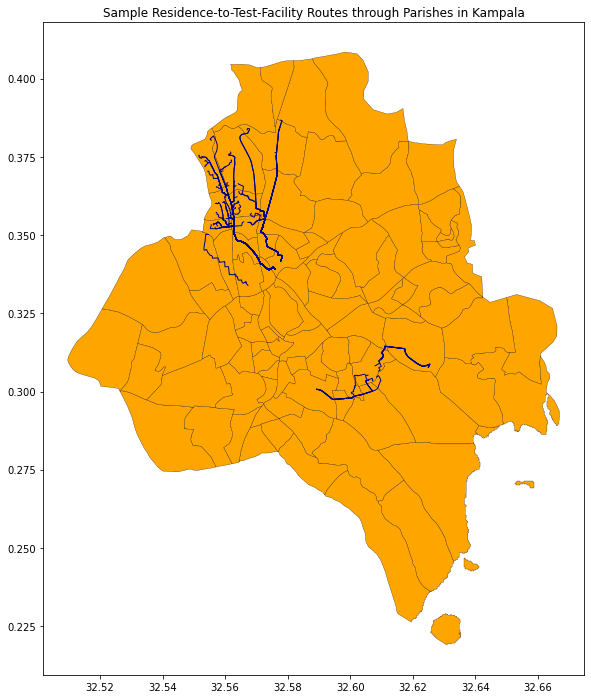

In [18]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(24, 12))
plt.title('Sample Residence-to-Test-Facility Routes through Parishes in Kampala')
parishes_gdf.plot(ax=ax1, color='orange', edgecolor='black', linewidth=0.25)
paired_cache_proj_gdf.to_crs('EPSG:4326').plot(ax=ax1, color='darkblue', linewidth=1)

In [19]:
paired_cache_proj_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   r_node          78 non-null     int64   
 1   parish_name     78 non-null     object  
 2   r_node_lat      78 non-null     float64 
 3   r_node_lon      78 non-null     float64 
 4   prj_lat         78 non-null     float64 
 5   prj_lon         78 non-null     float64 
 6   t_node          78 non-null     int64   
 7   t_node_lat      78 non-null     float64 
 8   t_node_lon      78 non-null     float64 
 9   PRJ_LAT         78 non-null     float64 
 10  PRJ_LON         78 non-null     float64 
 11  d1              78 non-null     float64 
 12  d2              78 non-null     float64 
 13  path_node_list  78 non-null     object  
 14  d3_euc          78 non-null     float64 
 15  d3_path_sum     78 non-null     float64 
 16  d3_shapely      78 non-null     object  
 17  d3_edge_at

In [20]:
paired_cache_proj_gdf[['parish_name', 'parish_num', 'd3_edge_attrs']].groupby(['parish_name']).mean()

,parish_num,d3_edge_attrs
parish_name,,
Bwaise I,5.3000000000,3373.2613000000
Bwaise Ii,6.0000000000,3490.2547000000
Bwaise Iii,5.0000000000,3242.0962000000
Kanyanya,5.8000000000,5013.7959000000
Kawempe I,6.9000000000,4554.1883000000
Kazo Ward,7.1000000000,4991.2327000000
Kisugu,4.3000000000,2890.0656000000
Makerere Iii,4.7500000000,2741.1730000000


<AxesSubplot:title={'center':'Mean D3 by edge attributes of Selected Kampala Parishes'}, ylabel='parish_name'>

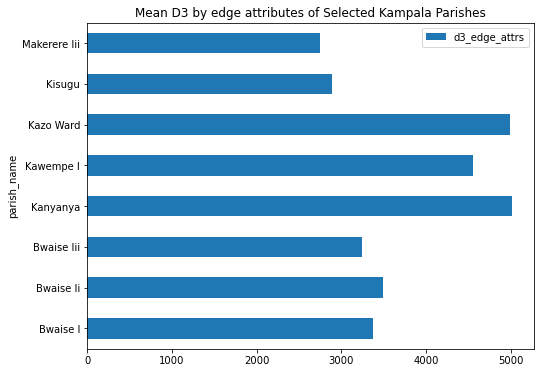

In [21]:
paired_cache_proj_gdf[['parish_name', 'd3_edge_attrs']]\
    .groupby(['parish_name']).mean()\
    .plot.barh(\
              figsize=(8, 6),
              title='Mean D3 by edge attributes of Selected Kampala Parishes')

<AxesSubplot:title={'center':'Number of Parishes Traversed from Residence to Testing Site\n in Selected Kampala Parishes'}, ylabel='parish_name'>

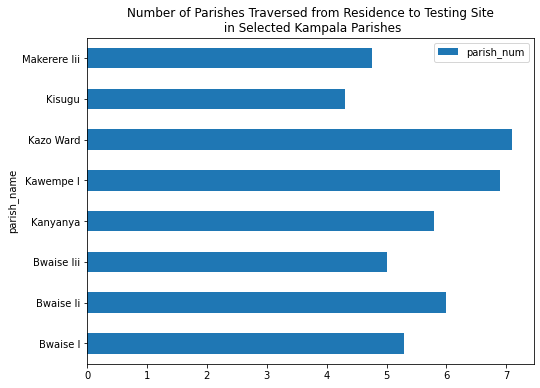

In [22]:
paired_cache_proj_gdf[['parish_name', 'parish_num']]\
    .groupby(['parish_name']).mean()\
    .plot.barh(\
              figsize=(8, 6),
              title='Number of Parishes Traversed from '+\
              'Residence to Testing Site\n in Selected Kampala Parishes')